✅ Using device: cpu


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Epoch 1/5: 100%|██████████| 221/221 [1:08:36<00:00, 18.63s/it]



📉 Epoch 1 Loss: 69.0626


Epoch 2/5: 100%|██████████| 221/221 [1:07:58<00:00, 18.46s/it]



📉 Epoch 2 Loss: 33.4326


Epoch 3/5: 100%|██████████| 221/221 [1:08:20<00:00, 18.55s/it]



📉 Epoch 3 Loss: 19.0077


Epoch 4/5: 100%|██████████| 221/221 [1:07:40<00:00, 18.37s/it]



📉 Epoch 4 Loss: 11.1811


Epoch 5/5: 100%|██████████| 221/221 [1:07:52<00:00, 18.43s/it]



📉 Epoch 5 Loss: 14.0545

✅ Accuracy: 0.9729

📊 Classification Report:
              precision    recall  f1-score   support

           0     0.9768    0.9922    0.9844       765
           1     0.9444    0.8500    0.8947       120

    accuracy                         0.9729       885
   macro avg     0.9606    0.9211    0.9396       885
weighted avg     0.9724    0.9729    0.9723       885



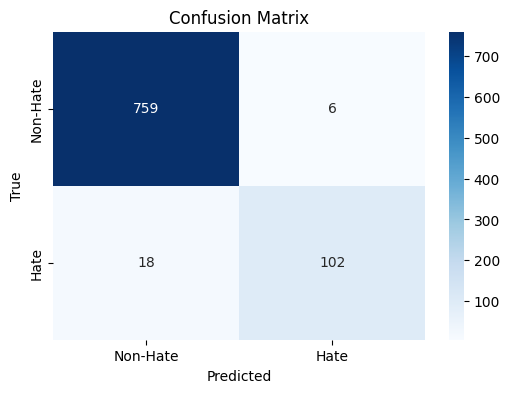

💾 Model saved to: /content/roberta_lstm_model.pth


In [ ]:

!pip install -q transformers datasets scikit-learn matplotlib seaborn

import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import RobertaTokenizer, RobertaModel
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.utils.class_weight import compute_class_weight
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
import os


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(" Using device:", device)


df = pd.read_csv('/content/reddit_labeled-3.csv')
df = df[['Content', 'Label']]

# Class weights
class_weights = compute_class_weight(class_weight="balanced", classes=np.unique(df.Label), y=df.Label)
class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)

# Train-test split
train_texts, test_texts, train_labels, test_labels = train_test_split(
    df['Content'].tolist(), df['Label'].tolist(), test_size=0.2, random_state=42)

tokenizer = RobertaTokenizer.from_pretrained('roberta-base')

def tokenize(texts, max_len=128):
    return tokenizer(texts, padding='max_length', truncation=True, max_length=max_len, return_tensors="pt")

# Dataset class
class HateSpeechDataset(Dataset):
    def __init__(self, texts, labels):
        self.encodings = tokenize(texts)
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

# DataLoader
train_dataset = HateSpeechDataset(train_texts, train_labels)
test_dataset = HateSpeechDataset(test_texts, test_labels)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16)


roberta = RobertaModel.from_pretrained('roberta-base')

# Classifier
class RoBERTaLSTMClassifier(nn.Module):
    def __init__(self, roberta, hidden_dim=128, num_classes=2):
        super().__init__()
        self.roberta = roberta
        self.lstm = nn.LSTM(input_size=768, hidden_size=hidden_dim, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(hidden_dim * 2, num_classes)

    def forward(self, input_ids, attention_mask):
        outputs = self.roberta(input_ids=input_ids, attention_mask=attention_mask)
        last_hidden_state = outputs.last_hidden_state
        lstm_out, _ = self.lstm(last_hidden_state)
        pooled = torch.mean(lstm_out, 1)
        return self.fc(pooled)

model = RoBERTaLSTMClassifier(roberta).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = torch.optim.Adam(model.parameters(), lr=2e-5)

# Training
epochs = 5
model.train()
for epoch in range(epochs):
    total_loss = 0
    for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}"):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids, attention_mask)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f"\n📉 Epoch {epoch + 1} Loss: {total_loss:.4f}")

# Evaluation
model.eval()
predictions, true_labels = [], []
with torch.no_grad():
    for batch in test_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids, attention_mask)
        preds = torch.argmax(outputs, dim=1)

        predictions.extend(preds.cpu().numpy())
        true_labels.extend(labels.cpu().numpy())

# Accuracy
acc = accuracy_score(true_labels, predictions)
print(f"\n Accuracy: {acc:.4f}")

# Classification report
print("\n Classification Report:")
print(classification_report(true_labels, predictions, digits=4))

# Confusion matrix heatmap
cm = confusion_matrix(true_labels, predictions)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Non-Hate', 'Hate'], yticklabels=['Non-Hate', 'Hate'])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


model_path = "/content/roberta_lstm_model.pth"
torch.save(model.state_dict(), model_path)
print(f" Model saved to: {model_path}")


In [ ]:
import torch
from transformers import RobertaTokenizer, RobertaModel
import torch.nn as nn

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Using:", device)


tokenizer = RobertaTokenizer.from_pretrained('roberta-base')

# Define the same model architecture
class RoBERTaLSTMClassifier(nn.Module):
    def __init__(self, roberta, hidden_dim=128, num_classes=2):
        super(RoBERTaLSTMClassifier, self).__init__()
        self.roberta = roberta
        self.lstm = nn.LSTM(input_size=768, hidden_size=hidden_dim,
                            batch_first=True, bidirectional=True)
        self.fc = nn.Linear(hidden_dim * 2, num_classes)

    def forward(self, input_ids, attention_mask):
        roberta_outputs = self.roberta(input_ids=input_ids, attention_mask=attention_mask)
        last_hidden_state = roberta_outputs.last_hidden_state
        lstm_out, _ = self.lstm(last_hidden_state)
        pooled = torch.mean(lstm_out, 1)
        return self.fc(pooled)

# Load model
roberta = RobertaModel.from_pretrained('roberta-base')
model = RoBERTaLSTMClassifier(roberta).to(device)

model.load_state_dict(torch.load("/content/roberta_lstm_model.pth", map_location=device))
model.eval()

# Prediction function
def predict(text):
    inputs = tokenizer(text, return_tensors='pt', truncation=True, padding='max_length', max_length=64)
    input_ids = inputs['input_ids'].to(device)
    attention_mask = inputs['attention_mask'].to(device)

    with torch.no_grad():
        outputs = model(input_ids, attention_mask)
        probs = torch.softmax(outputs, dim=1)
        pred = torch.argmax(probs, dim=1).item()

    label = " Hate" if pred == 1 else "Not Hate"
    confidence = probs[0][pred].item()

    print(f"\n Input: {text}")
    print(f" Prediction: {label}")
    print(f"Confidence: {confidence:.4f}")


predict(" you are full of shit , you deserve to be slaughtered ")
predict(" you are very good boy")
